In [151]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from scipy.stats import zscore
from scipy import stats
from tkinter import *
import pickle

from collections import Counter


import warnings
warnings.filterwarnings("ignore")


In [152]:
df = pd.read_csv("../../../data/kc_house_data.csv")

In [153]:
with open("ohe.pkl", "rb") as f:
    _ = pickle.load(f)

In [158]:
pd.set_option('display.max_columns', None)

In [162]:
df.drop(["id", "waterfront", "view","condition", "sqft_basement", "lat", "long"], axis=1, inplace=True)

In [163]:
df.head(1)

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,grade,sqft_above,yr_built,yr_renovated,zipcode,sqft_living15,sqft_lot15
0,10/13/2014,221900.0,3,1.0,1180,5650,1.0,7,1180,1955,0.0,98178,1340,5650


In [6]:
def rmse(predictions, targets):
    return np.sqrt(np.mean((predictions-targets)**2))

In [7]:
def model(x, target_df, standard=False, minmax=False):
        #does log work on a bunh of columns at once?
#         x = np.log(x)
        #x = np.log(x)
        
    #split data 
    X_train, X_test, y_train, y_test = train_test_split(x, target_df, random_state=42)
    
    #Implement scaler options if scaler parameters != None
    if minmax:
        scaler = MinMaxScaler()
        scaler.fit(X_train)
        X_train = scaler.transform(X_train)
        X_test = scaler.transform(X_test)
        
    if standard:
        scaler = StandardScaler()
        scaler.fit(X_train)
        X_train = scaler.transform(X_train)
        X_test = scaler.transform(X_test)
        
    #create model
    model = LinearRegression()
    #fit data to model
    model.fit(x, target_df)
    
    return model
    
    #Model coef
    df_column_names = x.columns
    coef = pd.DataFrame(list(zip(df_column_names, model.coef_)), columns = ["feature","weight"])\
    .sort_values("weight", ascending=False)
    
    #Make predictions
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)
    
    if log:
        pass
#         train_rmse = rmse(np.exp(train_pred), np.exp(y_train.values))
#         test_rmse = rmse(np.exp(test_pred), np.exp(y_test.values))
    else:
    
        #train rmse
        train_rmse = rmse(train_pred, y_train.values)
        #test rmse
        test_rmse = rmse(test_pred, y_test.values)

    return ( round(train_rmse,2), round(test_rmse, 2), coef, model)

In [8]:
def testmodel(x, target_df, standard=False, minmax=False, log=False):
        #does log work on a bunh of columns at once?
#         x = np.log(x)
        #x = np.log(x)
    if log:
        target_df = np.log(target_df)
        
    #split data 
    X_train, X_test, y_train, y_test = train_test_split(x, target_df, random_state=42)
    
    #Implement scaler options if scaler parameters != None
    if minmax:
        scaler = MinMaxScaler()
        scaler.fit(X_train)
        X_train = scaler.transform(X_train)
        X_test = scaler.transform(X_test)
        
    if standard:
        scaler = StandardScaler()
        scaler.fit(X_train)
        X_train = scaler.transform(X_train)
        X_test = scaler.transform(X_test)
        
    #create model
    model = LinearRegression()
    #fit data to model
    model.fit(x, target_df)
    
    
    #Model coef
    df_column_names = x.columns
    coef = pd.DataFrame(list(zip(df_column_names, model.coef_)), columns = ["feature","weight"])\
    .sort_values("weight", ascending=False)
    
    #Make predictions
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)
    
    if log:
        train_rmse = rmse(np.exp(train_pred), np.exp(y_train.values))
        test_rmse = rmse(np.exp(test_pred), np.exp(y_test.values))
    else:
    
        #train rmse
        train_rmse = rmse(train_pred, y_train.values)
        #test rmse
        test_rmse = rmse(test_pred, y_test.values)

    return ( round(train_rmse,2), round(test_rmse, 2), test_pred, y_test.values)

In [9]:
def top_entries(df):
    #df.corr().abs().unstack().sort_values(ascending=False).drop_duplicates()
    
    mat = df.corr().abs()
    
    # Remove duplicate and identity entries
    mat.loc[:,:] = np.tril(mat.values, k=-1)
    mat = mat[mat>0]

    # Unstack, sort ascending, and reset the index, so features are in columns
    # instead of indexes (allowing e.g. a pretty print in Jupyter).
    # Also rename these it for good measure.
    return (mat.unstack()
             .sort_values(ascending=False)
             .reset_index()
             .rename(columns={
                 "level_0": "feature_a",
                 "level_1": "feature_b",
                 0: "correlation"
             }))

In [10]:
def is_number(a):
    # will be True also for 'NaN'
    try:
        number = float(a) or number == int(a)
        return True
    except ValueError:
        return False

# import data

In [11]:
path = "../../../data/kc_house_data.csv"

In [12]:
df = pd.read_csv(path)

# Clean the data

In [13]:
def clean(df):
    entries_df['sqft_living'] = entries_df['sqft_living'].astype(float)
    entries_df['bedrooms'] = entries_df['bedrooms'].astype(float)
    entries_df['bathrooms'] = entries_df['bathrooms'].astype(float)
    entries_df['grade'] = entries_df['grade'].astype(float)
    entries_df['sqft_above'] = entries_df['sqft_above'].astype(float)
    entries_df['sqft_living15'] = entries_df['sqft_living15'].astype(float)
    entries_df['sqft_lot15'] = entries_df['sqft_lot15'].astype(float)
    entries_df['sqft_lot'] = entries_df['sqft_lot'].astype(float)
    entries_df['months_ago_sold'] = entries_df['months_ago_sold'].astype(float)
    entries_df['age'] = entries_df['age'].astype(float)
    entries_df['floors'] = entries_df['floors'].astype(float)
    
    df["age"] = df["yr_built"].map(lambda x: 2021 - x)
    df["months_ago_sold"] = df["date"].map(lambda date: float(date.split("/")[0]) + (2021- float(date.split("/")[2]) )*12)
    
    zip_code = df[['zipcode']]
    onehot = OneHotEncoder(sparse=False)
    onehot_data = onehot.fit_transform(zip_code)
    zip_code = pd.DataFrame(onehot_data, columns=onehot.get_feature_names())
    df = pd.concat([df,zip_code],axis=1)

    # Top cross correlations via function at head of notebook
    df["sqft_living&above"] = df["sqft_living"] * df["sqft_above"]
    df["sqft_living&grade"] = df["sqft_living"] * df["grade"]
    df["sqft_living&living15"] = df["sqft_living"] * df["sqft_living15"]
    df["grade&sqft_above"] = df["grade"] * df["sqft_living"]
    df["bathrooms&sqft_living"] = df["bathrooms"] * df["sqft_living"]
    df["sqft_above&sqft_living15"] = df["sqft_above"] *df["sqft_living15"]
    df["grade&sqft_above"] = df["grade"] * df["sqft_above"]
    df["grade&sqft_living15"] = df["grade"] * df["sqft_living15"]
    df["grade&sqft_above"] = df["grade"] * df["sqft_above"]

    df.drop(["waterfront", "yr_renovated", "view", "lat", 'yr_built', 'date', 'zipcode', 'id', 'sqft_basement', 'zipcode'], axis=1, inplace=True)
    df.dropna(inplace=True)

    #drop outliers
    z_scores = stats.zscore(df[['bedrooms','bathrooms','sqft_living','sqft_lot','floors','grade','sqft_above','sqft_living15','sqft_lot15', "price"]])
    abs_z_scores = np.abs(z_scores)
    filtered_entries = (abs_z_scores < 3).all(axis=1)
    df = df[filtered_entries]

    return df

### turn columns into floats

In [14]:
df['sqft_living'] = df['sqft_living'].astype(float)
df['bedrooms'] = df['bedrooms'].astype(float)
df['condition'] = df['condition'].astype(float)
df['grade'] = df['grade'].astype(float)
df['sqft_above'] = df['sqft_above'].astype(float)
df['yr_built'] = df['yr_built'].astype(float)
df['zipcode'] = df['zipcode'].astype(float)
df['sqft_living15'] = df['sqft_living15'].astype(float)
df['sqft_lot15'] = df['sqft_lot15'].astype(float)
df['sqft_lot'] = df['sqft_lot'].astype(float)

# Create new columns

In [15]:
df["age"] = df["yr_built"].map(lambda x: 2021 - x)

In [16]:
df["months_ago_sold"] = df["date"].map(lambda date: float(date.split("/")[0]) + (2021- float(date.split("/")[2]) )*12)

### Add zip code(categorical) columns

In [17]:
zip_code = df[['zipcode']]
onehot = OneHotEncoder(sparse=False)
onehot_data = onehot.fit_transform(zip_code)
zip_code = pd.DataFrame(onehot_data, columns=onehot.get_feature_names())
df = pd.concat([df,zip_code],axis=1)

In [18]:
with open('ohe.pkl', 'wb') as f:
    pickle.dump(onehot, f)

### Add cross product columns

In [19]:
# Top cross correlations via function at head of notebook
top = top_entries(df).dropna()

In [20]:
top = top[top["feature_a"].str.contains("&", "price")==False]
top = top[top["feature_b"].str.contains("&")==False]
top = top[top["feature_b"].str.contains("price")==False]

In [21]:
top[:10]

,feature_a,feature_b,correlation
0,yr_built,age,1.000000
1,sqft_living,sqft_above,0.876448
2,sqft_living,grade,0.762779
3,sqft_living,sqft_living15,0.756402
4,grade,sqft_above,0.756073
5,bathrooms,sqft_living,0.755758
6,sqft_above,sqft_living15,0.731767
7,sqft_lot,sqft_lot15,0.718204
8,grade,sqft_living15,0.713867
9,price,sqft_living,0.701917


In [22]:
df["sqft_living&above"] = df["sqft_living"] * df["sqft_above"]
df["sqft_living&grade"] = df["sqft_living"] * df["grade"]
df["sqft_living&living15"] = df["sqft_living"] * df["sqft_living15"]
df["grade&sqft_above"] = df["grade"] * df["sqft_living"]
df["bathrooms&sqft_living"] = df["bathrooms"] * df["sqft_living"]
df["sqft_above&sqft_living15"] = df["sqft_above"] *df["sqft_living15"]
df["grade&sqft_above"] = df["grade"] * df["sqft_above"]
df["grade&sqft_living15"] = df["grade"] * df["sqft_living15"]
df["grade&sqft_above"] = df["grade"] * df["sqft_above"]

### Drop useless columns

In [23]:
df.drop(["waterfront", "yr_renovated", "view", "lat", 'yr_built', 'date', 'zipcode', 'id', 'sqft_basement', 'zipcode'], axis=1, inplace=True)

### Drop na from dataset

In [24]:
df.dropna(inplace=True)

# Eliminate outliers

In [25]:
z_scores = stats.zscore(df[['bedrooms','bathrooms','sqft_living','sqft_lot','floors','grade','sqft_above','sqft_living15','sqft_lot15', "price"]])
abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 3).all(axis=1)

In [26]:
df = df[filtered_entries]

# Counter of how many times each unique element appears in categorical columns

In [27]:
Counter(df["age"]);

# Get ascending list of correlations

In [28]:
corrs = df.corr()["price"].sort_values(ascending=False).drop("price")

In [29]:
pd.DataFrame(corrs)[:10]

,price
sqft_living&grade,0.680787
grade,0.640878
sqft_living&living15,0.634868
sqft_living,0.631505
grade&sqft_living15,0.628235
bathrooms&sqft_living,0.609536
sqft_living&above,0.586148
grade&sqft_above,0.584144
sqft_living15,0.560833
sqft_above&sqft_living15,0.560066


# Create variable called target that contains price column of full df

In [30]:
target = df["price"]

# Create baseline model

In [31]:
baseline_df = df[[corrs.keys()[0]]]

In [32]:
testmodel(baseline_df, target)[:2]

(182336.69, 179507.76)

# Create model with top 3

In [33]:
top3_df = df[[corrs.keys()[0], corrs.keys()[1], corrs.keys()[2]]]

In [34]:
testmodel(top3_df, target)[:2]

(179317.18, 176639.52)

# Top 7 correlated

In [35]:
top7_df = df[[corrs.keys()[0], corrs.keys()[1], corrs.keys()[2], corrs.keys()[3], corrs.keys()[4], corrs.keys()[5], corrs.keys()[6]]]

In [36]:
testmodel(top7_df, target, standard=True)[:2]

(408594.04, 405954.27)

# All usable besides zip code

In [37]:
all_nozip_df = df[['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'grade','sqft_above', 'sqft_living15', 'sqft_lot15', 'age', 'months_ago_sold', 'sqft_living&above', 'sqft_living&grade', 'sqft_living&living15', 'grade&sqft_above', 'bathrooms&sqft_living', 'sqft_above&sqft_living15', 'grade&sqft_living15']]

In [38]:
testmodel(all_nozip_df, target)[:2]

(156101.43, 153769.06)

# All usable columns (zip code and cross multiplications added)

In [39]:
all_df = df.drop(['price', 'long', 'condition'],axis=1)

In [40]:
testmodel(all_df, target)[:2]

(105202.55, 105940.13)

In [41]:
all_use_preds = testmodel(all_df,target)[-2]

In [42]:
all_use_real = testmodel(all_df,target)[-1]

# All with minmax

In [43]:
testmodel(all_df, target, minmax=True)[:2]

(343163.73, 339071.15)

# All with standard

In [44]:
testmodel(all_df, target, standard=True)[:2]

(22900035624.97, 22759781361.72)

In [45]:
target

0        221900.0
1        538000.0
2        180000.0
3        604000.0
4        510000.0
           ...   
21592    360000.0
21593    400000.0
21594    402101.0
21595    400000.0
21596    325000.0
Name: price, Length: 20331, dtype: float64

# All with standard and log

In [46]:
testmodel(all_df, target, standard=True, log=True)[:2]

(inf, inf)

In [47]:
best = model(all_df, target)

# Price distribution skew

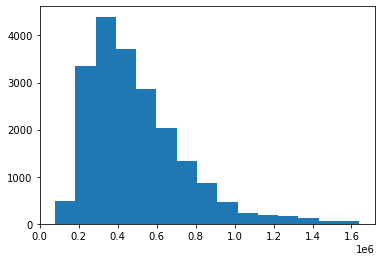

In [48]:
plt.hist(df.price, bins=15);

# Distribution of error in price

In [146]:
def quantile_error(y_pred, y_true, qant):
    quantiles = pd.DataFrame(pd.qcut(y_true, q=qant))
    e = y_pred - y_true
    quantiles['error'] = e
    quantiles.columns = ['price', 'error']
    error_df = quantiles.groupby('price').mean()['error']
    error_df = pd.DataFrame(error_df).reset_index()
    #sns.histplot(x=error_df["price"], y=error_df["error"])
    plt.rcParams["figure.figsize"] = (20, 10)
    figure =  error_df.plot.bar(x='price', y='error', rot=45)
    figure.set_title("Average Error by Price Interval",fontsize=24)
    figure.set_xlabel("Price Interval", fontsize=18)
    figure.set_ylabel("Average Error", fontsize=18)
    return figure

In [147]:
np.isnan(all_use_preds).sum()

0

In [148]:
np.isnan(all_use_real).sum()

0

<AxesSubplot:title={'center':'Average Error by Price Interval'}, xlabel='Price Interval', ylabel='Average Error'>

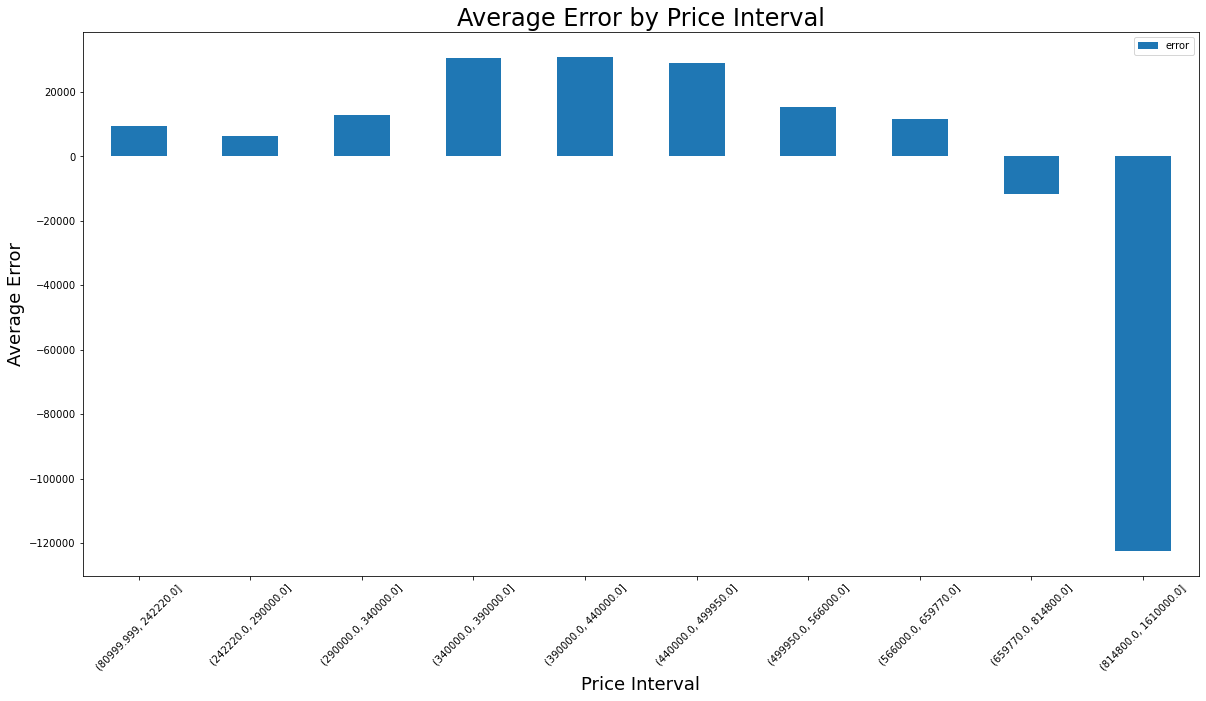

In [149]:
quantile_error(all_use_preds, all_use_real, 10)

# Feature importance

In [ ]:
best

# Pickle best model

In [ ]:
with open("model.pkl", "wb") as f:
    pickle.dump(best, f)